# Feature engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium
from dask import delayed
import dask
dask.config.set({"visualization.engine": "cytoscape"})

full = pd.read_csv('../data/full_dataset.csv')

pd.options.display.max_columns = None

In [2]:
full.head()

,movie_title,duration,genres,language,country,content_rating,budget,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_Other,director_name,actor_1_name,actor_2_name,actor_3_name,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_voted_users,num_user_for_reviews,gross_margin
0,The Spanish Prisoner,110.0,Drama|Mystery|Thriller,English,USA,PG,10000000.0,True,False,False,True,False,False,False,False,False,False,True,David Mamet,Ben Gazzara,Felicity Huffman,Campbell Scott,342.0,623.0,508.0,393.0,1722,10200000.0,7.3,578,97.0,18697,263.0,0.020000
1,Oceans,104.0,Documentary|Drama,French,France,G,40000000.0,True,False,False,False,False,False,False,False,False,False,True,Jacques Perrin,Pedro Armendáriz Jr.,Jacques Perrin,Rie Miyazawa,63.0,67.0,63.0,7.0,152,19406406.0,7.8,0,113.0,7630,42.0,-0.514840
2,Exorcist: The Beginning,125.0,Horror|Mystery|Thriller,English,USA,R,50000000.0,False,False,False,True,False,False,False,True,False,False,True,Renny Harlin,James D'Arcy,Alan Ford,Izabella Scorupco,212.0,613.0,422.0,394.0,1970,41814863.0,5.1,893,167.0,28635,308.0,-0.163703
3,First Knight,134.0,Action|Adventure|Romance|Thriller,English,USA,PG-13,55000000.0,False,False,True,True,False,True,True,False,False,False,False,Jerry Zucker,Julia Ormond,Ben Cross,John Gielgud,109.0,919.0,303.0,249.0,1695,37600435.0,5.9,0,53.0,55350,180.0,-0.316356
4,This Is It,111.0,Documentary|Music,English,USA,PG,60000000.0,False,False,False,False,False,False,False,False,False,False,True,Kenny Ortega,Misha Gabriel Hamilton,Mekia Cox,Judith Hill,197.0,433.0,208.0,6.0,679,71844424.0,7.3,0,136.0,33158,223.0,0.197407


## 0. Historic financials

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


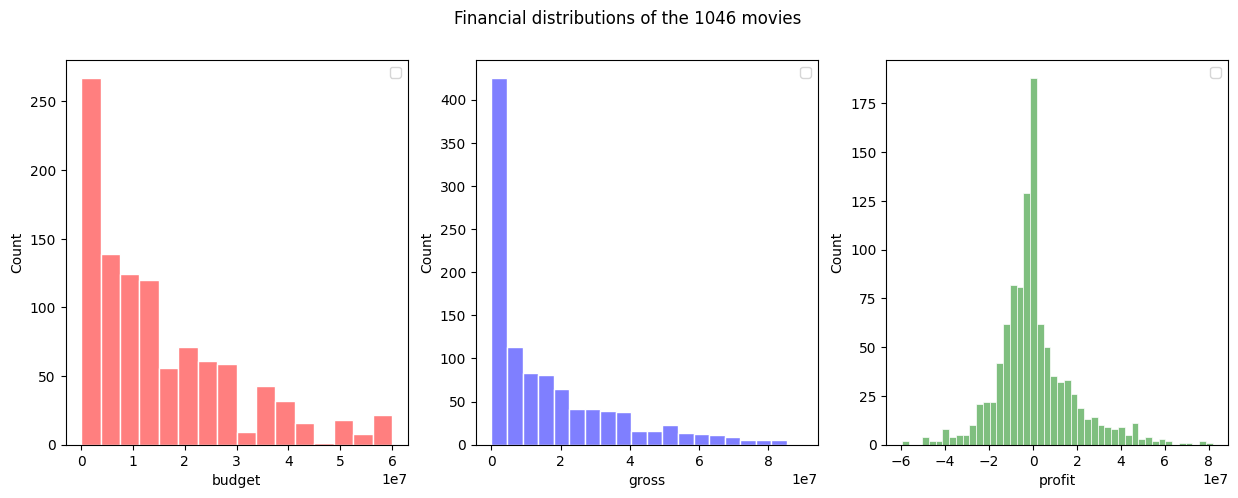

In [3]:
# Make a sns.kdeplot with two columns of the dataset
full["profit"] = full["gross"] - full["budget"]

financials = ["budget", "gross", "profit"]
colors = ["r", "b", "g"]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    sns.histplot(
        data=full, x=financials[i], ax=ax,
        fill=True, alpha=0.5, color= colors[i], edgecolor='white')
    ax.legend()
plt.suptitle(f'Financial distributions of the {full.shape[0]} movies')
plt.show()

## 1. Genres

In [4]:
full["genres_list"] = full["genres"].apply(lambda x: x.split("|"))
genre_counts = full["genres_list"].explode().value_counts()/full.shape[0]
# Create new columns with the top 10 genres
if not full.columns.str.contains("genre_").any():
    for genre in genre_counts.index[:10]:
        full["genre_"+genre] = full["genres_list"].apply(lambda x: genre in x)
    full["genre_Other"] = full["genres_list"].apply(lambda x: set(x).intersection(set(genre_counts.index[10:])) != set())

full.head()

,movie_title,duration,genres,language,country,content_rating,budget,genre_Drama,genre_Comedy,genre_Romance,genre_Thriller,genre_Crime,genre_Action,genre_Adventure,genre_Horror,genre_Family,genre_Fantasy,genre_Other,director_name,actor_1_name,actor_2_name,actor_3_name,director_facebook_likes,actor_1_facebook_likes,actor_2_facebook_likes,actor_3_facebook_likes,cast_total_facebook_likes,gross,imdb_score,movie_facebook_likes,num_critic_for_reviews,num_voted_users,num_user_for_reviews,gross_margin,profit,genres_list
0,The Spanish Prisoner,110.0,Drama|Mystery|Thriller,English,USA,PG,10000000.0,True,False,False,True,False,False,False,False,False,False,True,David Mamet,Ben Gazzara,Felicity Huffman,Campbell Scott,342.0,623.0,508.0,393.0,1722,10200000.0,7.3,578,97.0,18697,263.0,0.020000,200000.0,"[Drama, Mystery, Thriller]"
1,Oceans,104.0,Documentary|Drama,French,France,G,40000000.0,True,False,False,False,False,False,False,False,False,False,True,Jacques Perrin,Pedro Armendáriz Jr.,Jacques Perrin,Rie Miyazawa,63.0,67.0,63.0,7.0,152,19406406.0,7.8,0,113.0,7630,42.0,-0.514840,-20593594.0,"[Documentary, Drama]"
2,Exorcist: The Beginning,125.0,Horror|Mystery|Thriller,English,USA,R,50000000.0,False,False,False,True,False,False,False,True,False,False,True,Renny Harlin,James D'Arcy,Alan Ford,Izabella Scorupco,212.0,613.0,422.0,394.0,1970,41814863.0,5.1,893,167.0,28635,308.0,-0.163703,-8185137.0,"[Horror, Mystery, Thriller]"
3,First Knight,134.0,Action|Adventure|Romance|Thriller,English,USA,PG-13,55000000.0,False,False,True,True,False,True,True,False,False,False,False,Jerry Zucker,Julia Ormond,Ben Cross,John Gielgud,109.0,919.0,303.0,249.0,1695,37600435.0,5.9,0,53.0,55350,180.0,-0.316356,-17399565.0,"[Action, Adventure, Romance, Thriller]"
4,This Is It,111.0,Documentary|Music,English,USA,PG,60000000.0,False,False,False,False,False,False,False,False,False,False,True,Kenny Ortega,Misha Gabriel Hamilton,Mekia Cox,Judith Hill,197.0,433.0,208.0,6.0,679,71844424.0,7.3,0,136.0,33158,223.0,0.197407,11844424.0,"[Documentary, Music]"


## 2. Country distribution

In [5]:
country_view = full.groupby("country").agg({
    "movie_title": "count",
    "duration": "mean",
    "language": pd.Series.mode,
    "budget": "mean",
    "gross": "mean",
    "imdb_score": "mean"
})

country_view.columns = [
    "Number of movies",
    "Mean duration",
    "Most frequent language",
    "Mean movie budget",
    "Mean box office",
    "Mean IMDB score"
]
country_view[["Mean duration","Mean movie budget","Mean box office"]] = country_view[
    ["Mean duration","Mean movie budget","Mean box office"]].apply(lambda x: round(x,0), axis=1)
country_view["Mean IMDB score"] = country_view["Mean IMDB score"].apply(lambda x: round(x,2))

country_view["NAME"] = country_view.index

countries_shape = gpd.read_file("../data/countries_shape/ne_110m_admin_0_countries.shp")

countries_shape = countries_shape[["NAME", "POP_EST", "GDP_MD", "geometry"]]
countries_shape.NAME = countries_shape.NAME.str.replace("United States of America", "USA")
countries_shape.NAME = countries_shape.NAME.str.replace("United Kingdom", "UK")
countries_shape.NAME = countries_shape.NAME.str.replace("Czechia", "Czech Republic")

# # We don't have shapes for Hong Kong or Aruba
countries_full = countries_shape.merge(country_view, on="NAME")
countries_full = countries_full.map(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

countries_full.columns
countries_full.rename(columns={
        "NAME": "Country",
        "POP_EST": "Estimated population",
        "GDP_MD": "Estimated GDP (Mln$)",  
    }, inplace=True)


In [6]:
# set the figure size of the map
map_title = "The world of movies"
title_html = """
    <h3>{map_title}</h3>
    <p>Explore the map and click on countries to see the details</p>
""".format(map_title=map_title)

m = folium.Map(width=700, height=300)
m.get_root().html.add_child(folium.Element(title_html))

m = countries_full.explore(
    m=m,
    column="Country",
    scheme="naturalbreaks",
    tooltip= [
        "Country",
    ],
    popup=[
        "Country",
        "Estimated population",
        "Estimated GDP (Mln$)",
        "Number of movies",
        "Mean duration",
        "Most frequent language",
        "Mean movie budget",
        "Mean box office",
        "Mean IMDB score"
    ],
    tooltip_kwds=dict(labels=False),
    name="Countries",
    legend=False
)

folium.TileLayer("CartoDB positron", show=True).add_to(m)
folium.LayerControl(collapsed=True).add_to(m)

display(m)

## 2. Networks

In [7]:
import networkx as nx

# Create a source-target dataframe with the actors and movies
actor1 = full[["movie_title", "actor_1_name"]].rename(columns={"actor_1_name": "actor"})
actor2 = full[["movie_title", "actor_2_name"]].rename(columns={"actor_2_name": "actor"})
actor3 = full[["movie_title", "actor_3_name"]].rename(columns={"actor_3_name": "actor"})
actors = pd.concat([actor1, actor2, actor3], ignore_index=True)
actors["movie_title"] = actors["movie_title"].apply(lambda x: x.strip())

graph_data = actors.groupby("actor")["movie_title"].apply(list).reset_index()

In [62]:
%%time
g = nx.Graph()

for i, (actor, movies) in graph_data.iterrows():
    g.add_node(actor)
    print(f"{(i+1)/len(graph_data):.2%}", end="\r")
    for _, (actor2, movies2) in graph_data.iloc[i+1:].iterrows():
        common_movies = set(movies).intersection(set(movies2))
        if len(common_movies) > 0:
            g.add_edge(actor, actor2, weight=len(common_movies))



CPU times: total: 2min 7s
Wall time: 2min 8s


In [63]:
connections_actors = pd.DataFrame(g.degree())
connections_actors.columns = ["Actor", "Connections"]

In [68]:
betweenness_actors = pd.DataFrame(nx.betweenness_centrality(g), index=["Betweenness centrality"]).T
betweenness_actors["Actor"] = betweenness_actors.index
closeness_actors = pd.DataFrame(nx.closeness_centrality(g), index=["Closeness centrality"]).T
closeness_actors["Actor"] = betweenness_actors.index
actors_info = betweenness_actors.merge(connections_actors, on="Actor")
actors_info = actors_info.merge(closeness_actors, on="Actor")
actors_info.set_index("Actor", inplace=True)

In [71]:
actors_info.sort_values("Connections", ascending=False)

,Betweenness centrality,Connections,Closeness centrality
Actor,,,
Faizon Love,0.025157,16,0.087849
Nia Long,0.038684,15,0.098147
Larry Miller,0.030305,14,0.094729
Paul Sorvino,0.026339,14,0.089729
Bernie Mac,0.037991,14,0.094583
...,...,...,...
Yuanyuan Gao,0.000000,2,0.000879
Daryl Hannah,0.000000,1,0.056301
Don Brooks,0.000000,1,0.000440


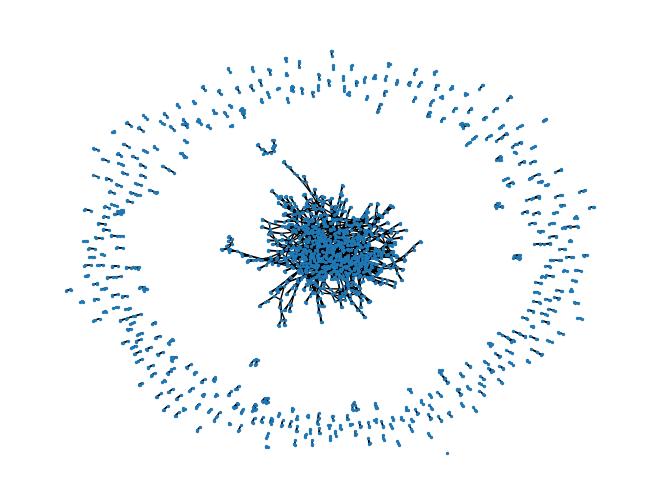

In [72]:
nx.draw(g, with_labels=False, node_size=2)

In [73]:
import pickle

pickle.dump(g, open('actors.pickle','wb'))

G = pickle.load(open('actors.pickle','rb'))

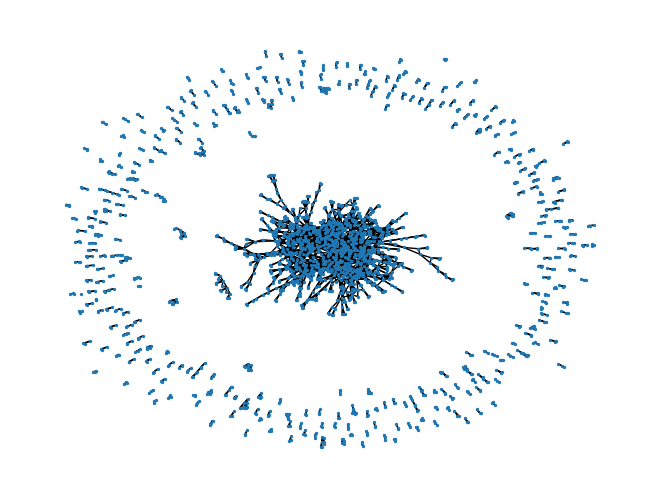

In [75]:
nx.draw(G, with_labels=False, node_size=2)